In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [84]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [85]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [86]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$



Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавая свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками.

Класс MeanTargetEncoderNoise должен иметь следующую сигнатуру:



In [87]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
#     def __init__(self, categorical, numeric):
        
#         ### Your code is here
    
#     def fit(self, X, y):

#         ### Your code is here

#         return self
        
#     def transform(self, df):
        
#         ### Your code is here
        
#         return temp
    

Разделите колонки на вещественные и категориальные. Приведите все категориальные колонки к типу `object`.

Далее применим наш кодировщик к `X_train, X_test`, так же как например мы применяем `StandardScaler`, чтобы проверить работоспособность нашего класса. Установите зерно датчика случайный чисел `np.random.seed(1)`.

После того, как вы изменили обучающую и тестовую выборки, сохраните первые 10 строк полученного промежуточного датафрейма обучающей выборки (`X_train`) в файл в формате csv с сепаратором `;`. Не забудьте индекс. Отправьте полученный файл в форму ниже.

Список колонок которые должны быть в файле для сдачи:
```py
cols = [
    "km_driven",
    "name",
    "year",
    "fuel",
    "seller_type",
    "transmission",
    "owner"
]
```

### Ваше решение


Разделение колонок на категориальные и числовые.

In [88]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


Реализация класса MeanTargetEncoderNoise.

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):


    def __init__(self, categorical, numeric):              
        ### Your code is here

        self.categorical = categorical
        self.numeric = numeric
        self.mean_target = {}
        self.C = 0.006

    
    def fit(self, X, y):
        ### Your code is here

        for col in self.categorical:
            df = pd.DataFrame({'feature': X[col], 'target': y})
            mean_target = df.groupby(['feature'])['target'].mean()
            self.mean_target[col] = mean_target
        
        for col in self.numeric:
            self.mean_target[col] = y.mean()

            return self
        
    def transform(self, X):
        ### Your code is here
        
        temp = X.copy()

        for col in self.categorical:
            temp[col] = temp[col].map(self.mean_target[col])
            temp[col] = temp[col]+self.C*np.random.randn(len(X))
            temp[col] = temp[col].fillna(0)
        
        for col in self.numeric:
            temp[col] = temp[col].fillna(self.mean_target[col])

        return temp

Проверка работы трансформера.

In [90]:
np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head(10)

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.478865,13.430921,50000,13.088541,12.609423,13.759065,12.964161
2290,12.111783,11.901925,70000,12.457036,12.620399,13.777324,12.962823
874,12.298593,13.336935,50000,12.455670,12.616451,12.645775,12.984195
1907,12.477658,13.055335,92198,12.463101,13.152012,12.637086,12.452642
3244,12.397144,12.857059,3240,12.454647,12.614863,12.627399,12.471970
1089,12.676751,13.438608,10000,12.455622,13.131947,12.644854,12.969999
3902,11.707359,11.497869,90000,12.449646,12.623791,12.639662,11.873113
2215,11.117254,11.502353,79000,12.452455,12.611637,12.632816,12.461447
3862,13.173893,13.339740,99700,13.085635,12.615428,12.632198,12.965374
705,12.997664,12.239908,124000,13.095024,12.616603,12.633892,12.460185


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [91]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [92]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

### Your code is here

result_test = {}
result_train = {}

for d in max_depth_list:
    pipe = Pipeline([
        ('custom_transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
        ('decision_tree', DecisionTreeRegressor(max_depth=d))
    ])

    pipe.fit(X_train, y_train)
    mse_train = mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{d}'
    result_train.update({max_depth: mse_train})
    result_test.update({max_depth: mse_test})

result_test

{'max_depth_3': 0.8184502153108858,
 'max_depth_5': 1.3884604913851668,
 'max_depth_8': 1.5777082939155207,
 'max_depth_12': 2.0055282316632255}

In [93]:
from sklearn.metrics import mean_squared_log_error


def best_hyperparameter(name, values, X_train, y_train, X_test, y_test):

    msle = []

    for value in values:
        pipeline = Pipeline([
            ('encoder', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
            ('model', DecisionTreeRegressor(**{name: value}))
        ])

        pipeline.fit(X_train, y_train)
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # msle_train = mean_squared_log_error(y_train, y_pred_train)
        msle_test = mean_squared_log_error(y_test, y_pred_test)

        print(f'Значение: {name}: {value}')
        print(f'MSLE test: {msle_test}')
        msle.append(msle_test)

    plt.plot(values, msle)
    plt.xlabel(name)
    plt.ylabel('msle')
    plt.title(f'MSLE vs {name}')
    plt.show()

    best_value = values[np.argmin(msle)]

    print(f'Лучшее значение {name}: {best_value}')
    print(f'Лучшее MLSE: {round(min(msle), 3)}')

    return best_value

Значение: max_depth: 3
MSLE test: 0.004237234728203979
Значение: max_depth: 5
MSLE test: 0.008755827750720457
Значение: max_depth: 8
MSLE test: 0.009792991213240064
Значение: max_depth: 12
MSLE test: 0.012744519637771314


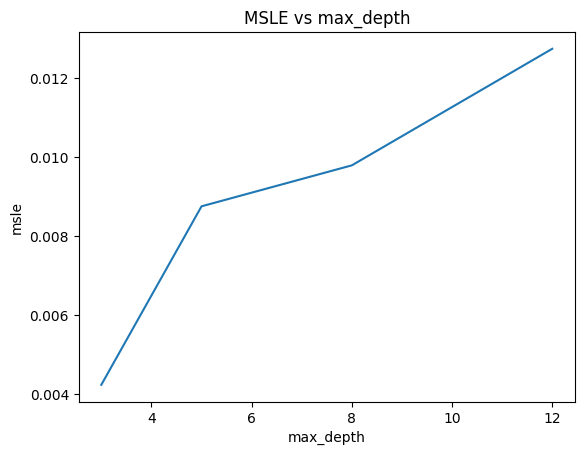

Лучшее значение max_depth: 3
Лучшее MLSE: 0.004


In [94]:
best_depth = best_hyperparameter('max_depth', max_depth_list, X_train, y_train, X_test, y_test)

Значение: min_samples_split: 10
MSLE test: 0.00880797573425713
Значение: min_samples_split: 50
MSLE test: 0.008738568827375264
Значение: min_samples_split: 100
MSLE test: 0.005709210289276718
Значение: min_samples_split: 500
MSLE test: 0.004770659739495118


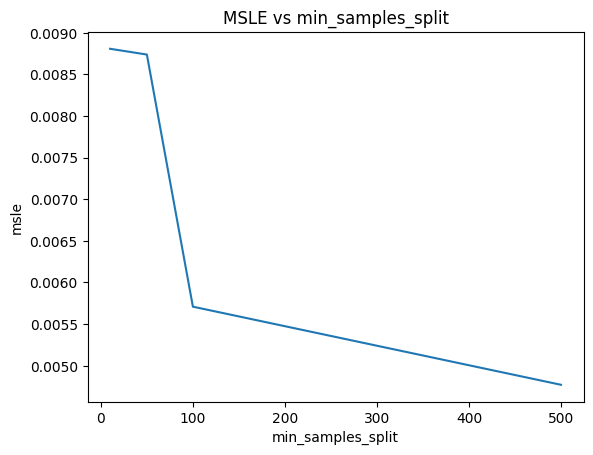

Лучшее значение min_samples_split: 500
Лучшее MLSE: 0.005


In [95]:
best_min_samples = best_hyperparameter('min_samples_split', min_samples_split_list, X_train, y_train, X_test, y_test)

Значение: min_impurity_decrease: 0
MSLE test: 0.012727581296151456
Значение: min_impurity_decrease: 0.1
MSLE test: 0.0027637242868925687
Значение: min_impurity_decrease: 0.15
MSLE test: 0.0028009092593604132
Значение: min_impurity_decrease: 0.2
MSLE test: 0.002778696523638971


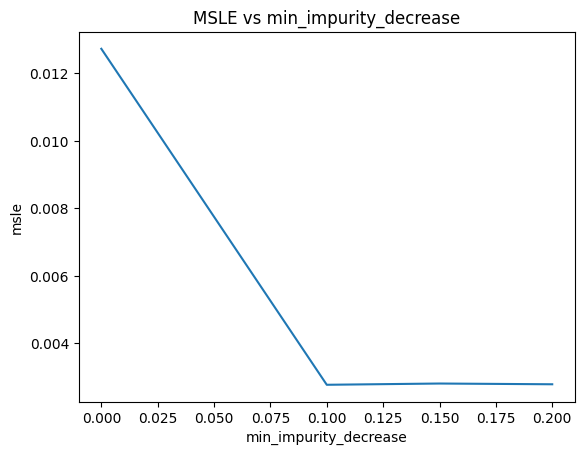

Лучшее значение min_impurity_decrease: 0.1
Лучшее MLSE: 0.003


In [96]:
best_min_impurity = best_hyperparameter('min_impurity_decrease', min_impurity_decrease_list, X_train, y_train, X_test, y_test)

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here

search = GridSearchCV(
    pipe,
    param_grid,
    scoring='neg_mean_squared_error',
    verbose=2
)

# search.fit(X_train, y_train)

# print(f'Best parameter (CV score={search.best_score_:.5f}):')
# print(search.best_params_)
# print(f'Лучшее качество на тесте: {search.score(X_test, y_test)}')